<a href="https://colab.research.google.com/github/kshitijd20/course-content/blob/dataloaders_kd/projects/fMRI/load_cichy_fMRI_MEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loader

## Summary
Here we will load data from Cichy et al. 2014 [1]. The data consist of fMRI responses from early visual cortex (EVC) and inferior temporal (IT) cortex and MEG responses at different timepoints in the form of representational dissimilarity matrices (RDMs) to 92 images. These images belong to different categories as shown in the Figure below. 



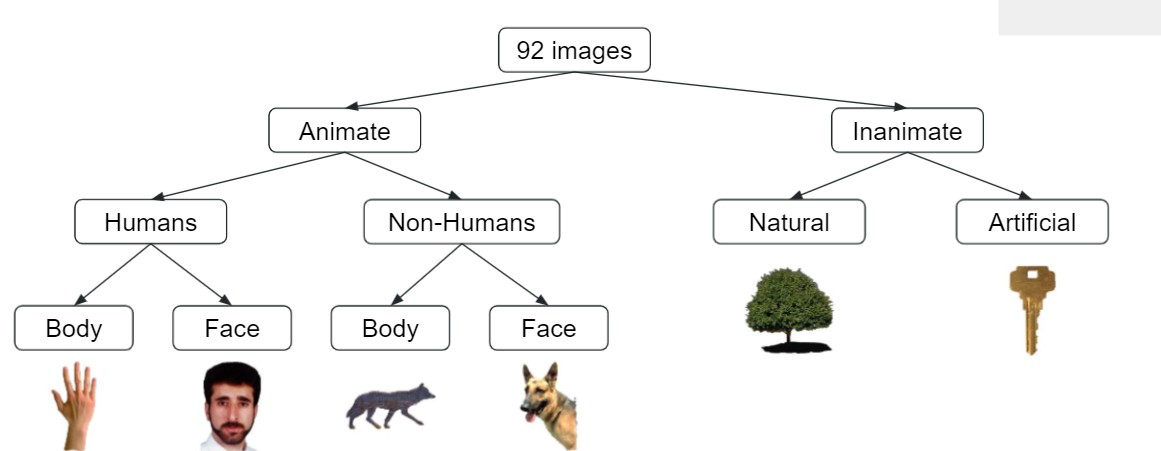

## Representational Similarity Analysis (RSA)
RSA is a method to relate signals
from different source spaces (such as behavior, neural
responses, DNN activations) by abstracting signals from
separate source spaces into a common similarity space. For
this, in each source space, condition-specific responses are
compared to each other for dissimilarity (e.g., by calculating
Euclidean distances between signals), and the values are
aggregated in so-called representational dissimilarity matrices (RDMs) indexed in rows and columns by the conditions
compared. RDMs thus summarize the representational
geometry of the source space signals. Different from source
space signals themselves, RDMs from different sources
spaces are directly comparable to each other for similarity
and thus can relate signals from different spaces 

The figure below illustrates how RSA can be applied to different problems by comparing RDMs of different modalities/species.

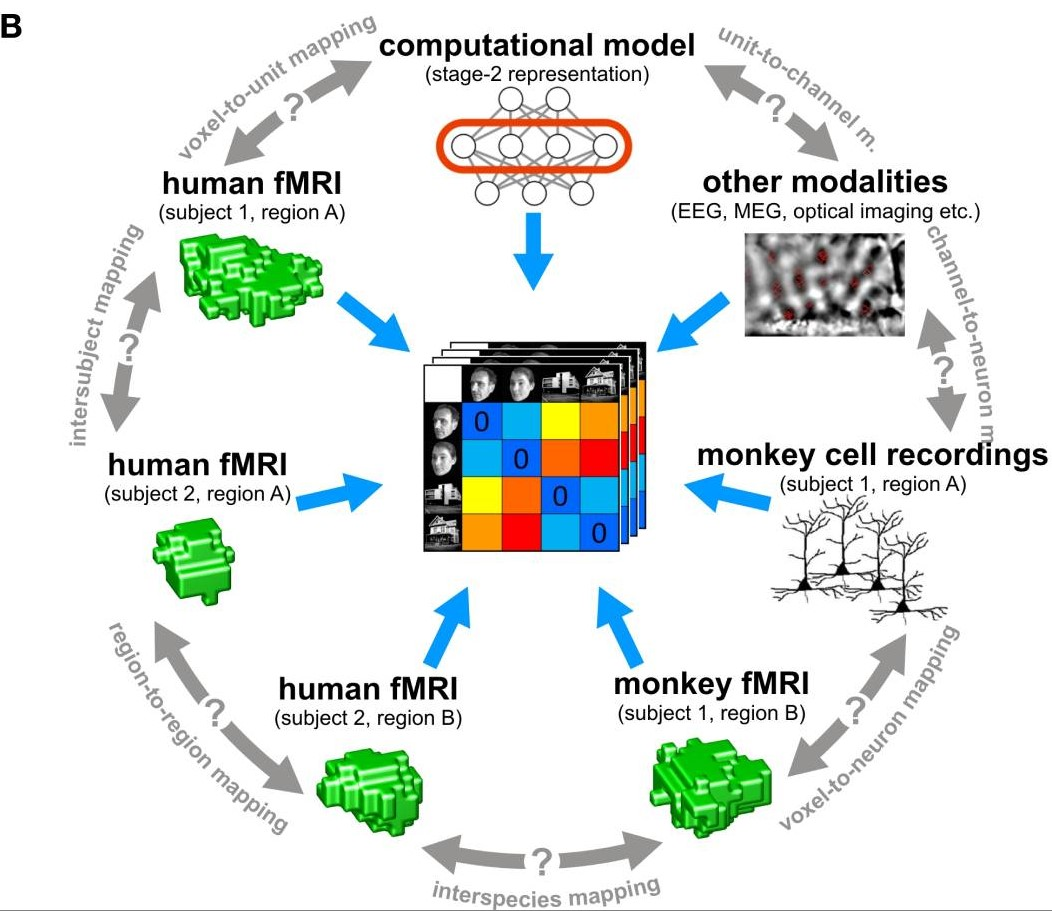

## Data from Cichy et al. 2014

In the cells below, we will download and visualize MEG and fMRI RDMs. Please refer Figure 1 in [1] to learn details about the image category order in RDMs 

In [104]:
# Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from tqdm import tqdm
from PIL import Image
from torchvision import transforms as trn
import scipy.io as sio
import h5py
import os
from pathlib import Path
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import ipywidgets
from ipywidgets import widgets, Play
import seaborn

def loadmat(matfile):
    """Function to load .mat files.
    Parameters
    ----------
    matfile : str
        path to `matfile` containing fMRI data for a given trial.
    Returns
    -------
    dict
        dictionary containing data in key 'vol' for a given trial.
    """
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

In [2]:
# Data download
Path("data").mkdir(parents=True, exist_ok=True)
!wget -qO data/data.zip -c https://osf.io/7vpyh/download


In [3]:
%%capture
!unzip -o data/data.zip -d data #unzip the files

In [4]:
!wget -qO data/92_Image_Set/cichy_stim_details.mat -c http://wednesday.csail.mit.edu/MEG1_MEG_Clear_Data/visual_stimuli.mat
def get_stim_details(path_to_file='data/92_Image_Set/cichy_stim_details.mat'):
  """
  acquire category names and binary features describing the Cichy images

  returns: stim_details (dict containing 5 keys: category (str), and four binary features (animate, human, natural, face)). 
                          each key holds an array giving the information for all categories
  """
  stim_dat = loadmat(path_to_file)['visual_stimuli']
  fields = ['category', 'human', 'face', 'animate', 'natural']
  stim_details = {field:[] for field in fields}
  for ii in range(92):
    for jj, field in enumerate(fields):
      stim_details[field].append(stim_dat[0,ii][jj][0])
  for field in fields[1:]:
    stim_details[field] = np.array(stim_details[field]).squeeze()
  return stim_details

stim_dict = get_stim_details()

# Each (key, value) pair of label_dict is of the form:
# key: label string, e.g., nonhuman bodypart
# value: list with the indicies for the given label
label_dict = {}
for label in np.unique(stim_dict['category']):
    label_dict[label] = [i for i, x in enumerate(stim_dict['category']) if x == label]

In [119]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

# Helper functions
def plot_RDM(RDM, metric=None, label=None, title=None, pmin=5, pmax=95):
    """Helper function for visualize a RDM."""
    if metric is not None:
        # Fill the upper portion of the RDM matrix
        RDM = np.tril(RDM) + np.triu(RDM.T, 1)
        RDM = np.nan_to_num(RDM)

        # Compute distance between stimulus pairs
        distance_matrix = pairwise_distances(RDM, RDM, metric=metric, n_jobs=-1)
        
    else:
        distance_matrix = RDM
        
    vmin = np.percentile(distance_matrix.reshape(-1), pmin)
    vmax = np.percentile(distance_matrix.reshape(-1), pmax)
    #distance_matrix = RDM 
    # Since the RDM matrix is symmetric we set upper triangular values to NaN
    distance_matrix[np.triu_indices(distance_matrix.shape[0], 1)] = np.nan
    # plot the RDM at given timepoint
    plt.imshow(distance_matrix, cmap="viridis", vmin=vmin, vmax=vmax)
    plt.title("RDM")
    if title is not None:
        plt.title(title)
    cbar = plt.colorbar()
    plt.xlabel("Stimuli")
    plt.ylabel("Stimuli")
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Dissimilarity Measure', rotation=270)
    if label is not None:
        cbar.ax.set_ylabel(label, rotation=270)
        
def plot_RDMs(RDM_dict, metric="chebyshev"):
    n_col = len(RDM_dict)
    fig, axs = plt.subplots(1, n_col, figsize=(4.5 * len(RDM_dict), 4.5))
    for i, (label, RDM) in enumerate(RDM_dict.items()):
        ax = axs[i]
        ax.set_title('%s' % label)
        
        # Fill the upper portion of the RDM matrix
        RDM = np.tril(RDM) + np.triu(RDM.T, 1)
        RDM = np.nan_to_num(RDM)
        
        # Compute distance between stimulus pairs
        distance_matrix = pairwise_distances(RDM, RDM, metric=metric, n_jobs=-1)
        
        # Since the RDM matrix is symmetric we set upper triangular values to NaN
        distance_matrix[np.triu_indices(distance_matrix.shape[0], 1)] = np.nan 
        pts = ax.imshow(distance_matrix, cmap="bwr")
        ax.set_xlabel('Stimuli')
        ax.set_ylabel('Stimuli')
        ax.set_xticks([])
        ax.set_yticks([])
        cbar = fig.colorbar(pts, ax=ax)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('Dissimilarity Measure', rotation=270)
        
def get_RDM_lowd(RDM, metric='correlation'):
    """Compute a low-dimensional representation of a RDM."""
    
    # Fill the upper portion of the RDM matrix
    RDM = np.tril(RDM) + np.triu(RDM.T, 1)
    RDM = np.nan_to_num(RDM)
    
    # Compute distance between stimulus pairs
    distance_matrix = pairwise_distances(RDM, RDM, metric=metric, n_jobs=-1)
    
    # First do PCA to reduce dimensionality to 20 dimensions so that tSNE is faster
    RDM_lowd = PCA(n_components=min(20, distance_matrix.shape[0]), random_state=0).fit_transform(distance_matrix)

    # Then do tSNE to reduce dimensionality to 2 dimensions
    RDM_lowd = TSNE(n_components=2, random_state=0).fit_transform(RDM_lowd)
    
    return RDM_lowd

def plot_RDM_lowd(RDM_lowd, label_dict, title=None):
    """Plot a low-dimensional representation of a RDM."""

    x, y = RDM_lowd[:, 0], RDM_lowd[:, 1]
    for label, idxs in label_dict.items():
      plt.scatter( x[idxs[:]], y[idxs[:]], marker = 'o', s = 50)
    plt.title('RDM')
    if title is not None:
        plt.title(title)
    plt.legend(label_dict.keys(), bbox_to_anchor=(1, .8), loc="upper left")
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    #plt.xticks([])
    #plt.yticks([])
    
def plot_RDMs_lowd(RDM_lowd_dict, label_dict, title=None):
    """Plot low-dimensional representations of RDMs."""
    
    n_col = len(RDM_lowd_dict)
    fig, axs = plt.subplots(1, n_col, figsize=(4.5 * len(RDM_lowd_dict), 4.5))
    
    for i, (label, RDM_lowd) in enumerate(RDM_lowd_dict.items()):
        ax = axs[i]
        ax.set_title('%s' % label)
        x, y = RDM_lowd[:, 0], RDM_lowd[:, 1]
        for label, idxs in label_dict.items():
            ax.scatter( x[idxs[:]], y[idxs[:]], marker = 'o', s = 50)
        ax.set_xlabel('Stimuli')
        ax.set_ylabel('Stimuli')

    fig.legend(label_dict.keys(), bbox_to_anchor=(1, .8), loc="upper left")

## Loading MEG RDMs

In [62]:
# Load MEG RDMs for each time point for all subjects all sessions
MEG_RDMs = loadmat("data/MEG_decoding_RDMs.mat")['MEG_decoding_RDMs']
print(MEG_RDMs.shape)  

(16, 2, 1301, 92, 92)


Shape of RDM is num_subjects x num_sessions x num_timepoints x num_stimulus x num_stimulus

In [63]:
# average RDM across subjects and sessions
MEG_RDMs_sub_averaged = np.mean(MEG_RDMs,axis=(0,1))
del MEG_RDMs

In [64]:
@widgets.interact( MEG_RDMs=widgets.fixed(MEG_RDMs_sub_averaged),
                   metric=widgets.fixed(None),
                   timepoint=widgets.IntSlider(min=0, max=600, step=20, value=420, description='t (ms):') )
def plot_MEG_RDMs(MEG_RDMs, metric=None, timepoint=420):
    """Helper function for visualize MEG RDMs with an interactive 
    slider for the timepoint."""
    # Load RDM at a given timepoint 
    # +100 as the RDMs provided are from -100ms to 1000ms after the stimulus onset
    RDM = np.array(MEG_RDMs[timepoint+100])
    title = "MEG RDM at t = " + str(timepoint) + " ms"
    label = "Decoding Accuracy"
    plot_RDM(RDM, label=label, title=title)

interactive(children=(IntSlider(value=420, description='t (ms):', max=600, step=20), Output()), _dom_classes=(…

## Loading fMRI RDMs

In [9]:
fMRI_file = 'data/92_Image_Set/target_fmri.mat'  # path of fMRI RDM file
fMRI_RDMs = loadmat(fMRI_file)  # load the fMRI RDMs
print(fMRI_RDMs.keys())
print(fMRI_RDMs['EVC_RDMs'].shape)

dict_keys(['EVC_RDMs', 'IT_RDMs'])
(15, 92, 92)


fMRI_RDMs is a dictionary with keys 'EVC_RDMs' and 'IT_RDMs' corresponding to ROIs EVC and IT respectively. The shape of each RDM is num_subjects x num_stimulus x num_stimulus

In [10]:
# average RDM across subjects
fMRI_RDMs_sub_averaged = fMRI_RDMs.copy()
for k, v in fMRI_RDMs.items():
    fMRI_RDMs_sub_averaged[k] = np.mean(v, axis=0)
del fMRI_RDMs

In [11]:
@widgets.interact( fMRI_RDMs=widgets.fixed(fMRI_RDMs_sub_averaged),
                   ROI=widgets.Dropdown(options=['EVC', 'IT'], value='IT') )
def plot_fMRI_RDMs(fMRI_RDMs, ROI='IT'):
    """Helper function for visualize fMRI RDMs with an interactive 
    dropdown menu for the ROI."""
    # Load RDM at a given ROI 
    RDM = np.array(fMRI_RDMs[ROI + "_RDMs"])
    title = ROI + " RDM"
    label = "1 - correlation"
    plot_RDM(RDM, label=label, title=title)

interactive(children=(Dropdown(description='ROI', index=1, options=('EVC', 'IT'), value='IT'), Output()), _dom…

# Example Analyses

Below we will perform two analyses:

1.   MEG-fMRI comparison: To find out at which timepoint MEG representation is similar to a given ROI's representation. 
2.   MEG-Deep Neural Network (DNN) comparison: To find out at which timepoint MEG representation is similar to a given DNN layer's representation. 

In other words, the comparison will inform us about the sequential order of visual feature processing in the cortex. 


In [12]:
# RDM Comparison functions

from scipy.stats import spearmanr

def RSA_spearman(rdm1,rdm2):
    """
    computes and returns the spearman correlation between lower triangular 
    part of the input rdms. We only need to compare either lower or upper 
    triangular part of the matrix as RDM is symmetric
    """
    # get lower triangular part of the RDM1 
    lt_rdm1 = get_lowertriangular(rdm1)
    # get lower triangular part of the RDM1 
    lt_rdm2 = get_lowertriangular(rdm2)
    # return Spearman's correlation between lower triangular part of rdm1 & rdm2
    return spearmanr(lt_rdm1, lt_rdm2)[0]

def get_lowertriangular(rdm):
    """
    returns lower triangular part of the matrix
    """
    num_conditions = rdm.shape[0]
    return rdm[np.tril_indices(num_conditions,-1)]

## MEG-fMRI Comparison

In [13]:
# Correlating MEG RDMs with fMRI RDMs
num_timepoints = MEG_RDMs_sub_averaged.shape[0] # get number of timepoints

# initialize a dictionary to store MEG and ROI RDM correlation at each timepoint
MEG_correlation = {}
ROIs = ['EVC','IT']
for ROI in ROIs:
  MEG_correlation[ROI] = []

# for loop that goes over MEG RDMs at all time points and correlate with ROI RDMs
for t in range(num_timepoints):
  MEG_RDM_t = MEG_RDMs_sub_averaged[t,:,:]
  for ROI in ROIs:
    ROI_RDM = fMRI_RDMs_sub_averaged[ROI + '_RDMs']
    MEG_correlation[ROI].append(RSA_spearman(ROI_RDM, MEG_RDM_t))

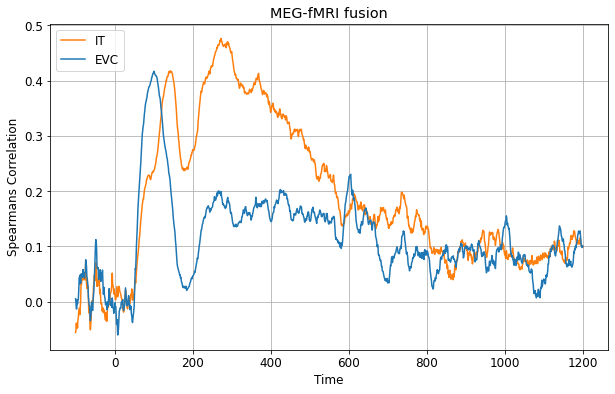

In [14]:
# Plotting MEG-fMRI comparison

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

time_range = range(-100,1201)
ax.plot(time_range, MEG_correlation['IT'], color='tab:orange', label='IT')
ax.plot(time_range, MEG_correlation['EVC'], color='tab:blue', label='EVC')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Spearmans Correlation')
ax.set_title('MEG-fMRI fusion')
ax.grid(True)
ax.legend(loc='upper left');

## MEG-DNN Comparison

### Creating DNN (AlexNet) RDMs

In [15]:
# AlexNet Definition
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

# Here we redefine AlexNet differently from torchvision code for better understanding
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)
        return out1, out2, out3,out4, out5, out6,out7,out8


def alexnet(pretrained=False, **kwargs):
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model 

In [16]:
# Feature extraction code
def load_alexnet(model_checkpoints):
    """This function initializes an Alexnet and load
    its weights from a pretrained model. Since we redefined model in a different
    way we have to rename the weights that were in the pretrained checkpoint.
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """

    model = alexnet()
    # Load checkpoint
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)

    # Rename the checkpoint keys according to new definition
    model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    # initialize model with pretrained weights 
    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model

def get_activations_and_save(model, image_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    image_list : list
        the list contains path to all images.
    activations_dir : str
        save path for extracted features.
    """

    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # for all images in the list generate and save activations
    for image_file in tqdm(image_list):
        
        # open image
        img = Image.open(image_file)
        image_file_name = os.path.split(image_file)[-1].split(".")[0]

        # apply transformations before feeding to model
        input_img = V(resize_normalize(img).unsqueeze(0))
        if torch.cuda.is_available():
            input_img=input_img.cuda()
        x = model.forward(input_img)

        activations = []
        for i,feat in enumerate(x):
            activations.append(feat.data.cpu().numpy().ravel())

        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, image_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            np.save(save_path,activations[layer])


In [17]:
# get the paths to all the images in the stimulus set
image_dir = 'data/92_Image_Set/92images'
image_list = glob.glob(image_dir + '/*.jpg')
image_list.sort()
print('Total Number of Images: ', len(image_list))
cwd = os.getcwd() # get current working directory
save_dir = os.path.join(cwd, "content/activations_alexnet")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

######### load Alexnet initialized with pretrained weights ###################
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = os.path.join(cwd, "content/alexnet.pth")
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, checkpoint_path)
model = load_alexnet(checkpoint_path)
##############################################################################

######### get and save activations ################################
activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, activations_dir)
###################################################################

Total Number of Images:  92


/opt/conda/lib/python3.8/site-packages/torch/serialization.py:701: UserWarning: Legacy tensor constructor is deprecated. Use: torch.tensor(...) for creating tensors from tensor-like objects; or torch.empty(...) for creating an uninitialized tensor with specific sizes. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_new.cpp:476.)
  tensor = tensor_type().set_(storage, storage_offset, size, stride)
  0%|          | 0/92 [00:00<?, ?it/s]

-------------Saving activations ----------------------------


100%|██████████| 92/92 [00:00<00:00, 130.58it/s]


In [18]:
num_layers = 8  # number of layers in the model
layers = []

for i in range(num_layers):
  layers.append("layer" + "_" + str(i+1))

Model_RDMs = {}

# create RDM for each layer from activations
for layer in layers:
  activation_files =  glob.glob(activations_dir + '/*' + layer + '.npy')
  activation_files.sort()
  activations = []
  # Load all activations
  for activation_file  in activation_files:
    activations.append(np.load(activation_file))
  activations = np.array(activations)

  # calculate Pearson's distance for all pairwise comparisons 
  Model_RDMs[layer] = 1-np.corrcoef(activations)

In [19]:
# Visualize model RDMs
options = [(k.replace('_', ' ').capitalize(), i+1) for k, i in zip(Model_RDMs.keys(), range(8))]
@widgets.interact( Model_RDMs=widgets.fixed(Model_RDMs),
                   layer=widgets.SelectionSlider(options=options, 
                                                 value=8,
                                                 description='AlexNet') )
def plot_Model_RDMs(Model_RDMs, layer=8):
    """Helper function for visualize Model RDMs with an interactive 
    slider for the layer index."""
    # Load RDM at a given layer
    RDM = np.array(Model_RDMs['layer_' + str(layer)])
    title = "Model's Layer " + str(layer) + " RDM"
    label = "1 - correlation"
    plot_RDM(RDM, label=label, title=title)

interactive(children=(SelectionSlider(description='AlexNet', index=7, options=(('Layer 1', 1), ('Layer 2', 2),…

### Comparing MEG RDMs with AlexNet RDMs

In [20]:
# Correlating MEG RDMs with DNN RDMs

num_timepoints = MEG_RDMs_sub_averaged.shape[0] #get number of timepoints

# initialize a dictionary to store MEG and DNN RDM correlation at each timepoint
for layer in layers:
  MEG_correlation[layer] = []

# for loop that goes over MEG RDMs at all time points and correlate with DNN RDMs
for t in range(num_timepoints):
  MEG_RDM_t = MEG_RDMs_sub_averaged[t,:,:]
  for layer in layers:
    model_RDM = Model_RDMs[layer]
    MEG_correlation[layer].append(RSA_spearman(model_RDM,MEG_RDM_t))

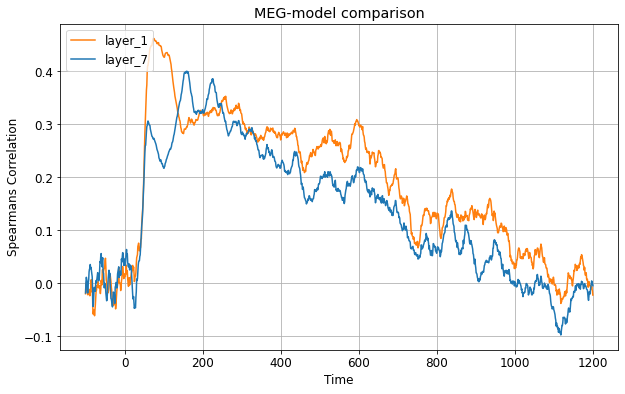

In [21]:
# Plotting MEG-DNN comparison
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

time_range = range(-100,1201)
ax.plot(time_range, MEG_correlation['layer_1'], color='tab:orange', label='layer_1')
ax.plot(time_range, MEG_correlation['layer_7'], color='tab:blue', label='layer_7')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Spearmans Correlation')
ax.set_title('MEG-model comparison')
ax.grid(True)
ax.legend(loc='upper left');

### Comparing 'decoding time' RDMs with AlexNet RDMs

In [22]:
# 'Decoding time' RDM
decoding_time_RDM = np.array(np.argmax(MEG_RDMs_sub_averaged, axis=0), dtype=np.float32)

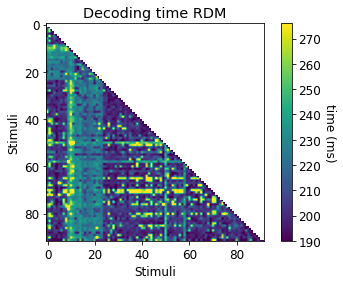

In [121]:
pmin, pmax = 5, 95 
plot_RDM(decoding_time_RDM, metric='chebyshev', pmin=pmin, pmax=pmax, label='time (ms)', title='Decoding time RDM')

In [24]:
# Correlating 'decoding time' RDMs with DNN RDMs

# initialize a dictionary to store MEG and DNN RDM correlation at each timepoint
decoding_time_correlation = {}
for layer in layers:
  decoding_time_correlation[layer] = []

# for loop that goes over MEG RDMs at all time points and correlate with DNN RDMs
for layer in layers:
    model_RDM = Model_RDMs[layer]
    decoding_time_correlation[layer].append(RSA_spearman(model_RDM, decoding_time_RDM))
    
for k, v in decoding_time_correlation.items():
    pass
    # print(f"{k.replace('_', ' ').capitalize()}: {v[0]:7.4f}")
    

## Dimensionality reduction of representations

We can visualize a dimensionality-reduced version of the internal representations of the human neocortex or CNN internal representations in order to potentially uncover informative structure. Here, we use PCA to reduce the dimensionality to 20 dimensions, and then use tSNE to further reduce dimensionality to 2 dimensions. We use the first step of PCA so that tSNE runs faster (this is standard practice in the field).

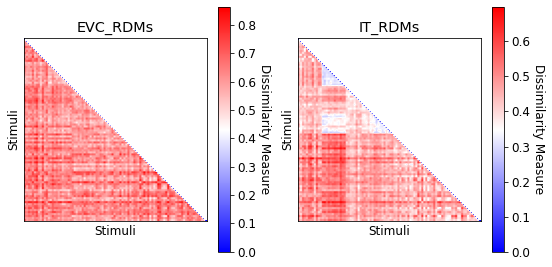

In [25]:
EVC_RDM = np.array(fMRI_RDMs_sub_averaged["EVC" + "_RDMs"])
IT_RDM = np.array(fMRI_RDMs_sub_averaged["IT" + "_RDMs"])
RDM_dict = {}
RDM_dict["EVC_RDMs"] = EVC_RDM
RDM_dict["IT_RDMs"] = IT_RDM

plot_RDMs(RDM_dict, metric='chebyshev')

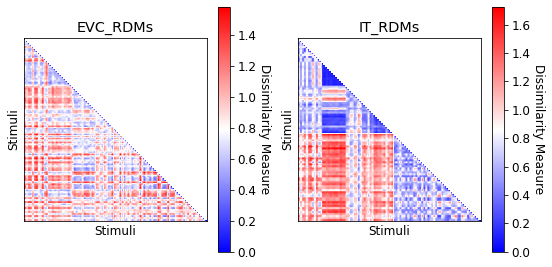

In [26]:
plot_RDMs(RDM_dict, metric='correlation')

In [98]:
@widgets.interact( fMRI_RDMs=widgets.fixed(RDM_dict),
                   ROI=widgets.Dropdown(options=['EVC', 'IT'], value='IT') )
def _plot_RDMs(fMRI_RDMs, ROI='EVC'):
    """Helper function for visualize fMRI RDMs in 2D space with an interactive 
    dropdown menu for the ROI."""
    # Load RDM at a given ROI 
    RDM = np.array(fMRI_RDMs[ROI + "_RDMs"])
    RDM_lowd = get_RDM_lowd(RDM, metric='chebyshev')
    title = ROI + " RDM"
    plot_RDM_lowd(RDM_lowd, label_dict, title=title)

interactive(children=(Dropdown(description='ROI', index=1, options=('EVC', 'IT'), value='IT'), Output()), _dom…

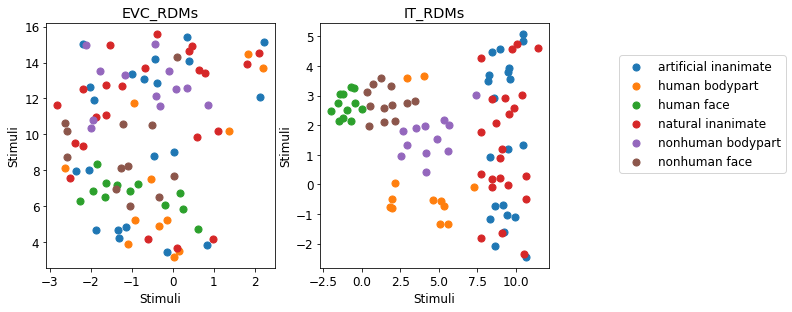

In [99]:
RDM_lowd_dict = {label: get_RDM_lowd(RDM, metric='chebyshev') 
                 for label, RDM in RDM_dict.items()}
plot_RDMs_lowd(RDM_lowd_dict, label_dict)

In [122]:
#timepoint=widgets.IntSlider(min=0, max=600, step=1, value=0, description='t (ms):'),
@widgets.interact( MEG_RDMs=widgets.fixed(MEG_RDMs_sub_averaged),
                   label_dict=widgets.fixed(label_dict),
                   timepoint=Play(min=0, max=1201, step=1, value=50, interval=500, description='t (ms):') 
                 )
def plot_MEG_RDMs_lowd(MEG_RDMs, timepoint=50):
    """Helper function for visualize MEG RDMs with an interactive 
    slider for the timepoint."""
    # Load RDM at a given timepoint 
    # +100 as the RDMs provided are from -100ms to 1000ms after the stimulus onset
    RDM = np.array(MEG_RDMs[timepoint+100])
    RDM_lowd = get_RDM_lowd(RDM, metric='correlation')
    title = "MEG RDM at t = " + str(timepoint) + " ms"
    plot_RDM_lowd(RDM_lowd, label_dict, title=title)

interactive(children=(Play(value=50, description='t (ms):', interval=500, max=1201), Output()), _dom_classes=(…

# References
1.   [Resolving human object recognition in space and time. Cichy et al. Nature Neuroscience 2014](https://www.nature.com/articles/nn.3635)
2.   [Representational similarity analysis – connecting the branches of systems neuroscience. Kriegeskorte et al. Front. Syst. Neurosci., 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)



